# Setup

### Importy

In [1]:
# Odkomentować, aby pobrać pakiet
# %pip install numpy
# %pip install pandas
# %pip install scikit-learn
# %pip install seaborn
# %pip install matplotlib
# %pip install tensorflow
# %pip install tensorflow_datasets
# %pip install sounddevice
# %pip install librosa

In [2]:
import time

import numpy as np
from sklearn import metrics
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from IPython import display
import librosa
import sounddevice as sd

2024-06-14 21:45:04.351890: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-14 21:45:05.433054: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Załadowanie dataset'u

In [4]:
datasets, info = tfds.load("speech_commands", 
                           split=["train", "validation", "test"],
                           with_info=True,
                           as_supervised=True)
train_ds, val_ds, test_ds = datasets
label_names = info.features["label"].names

def fixup(audio, label):
    # zmiana typu z int na float
    audio = audio / np.iinfo(np.int16).max

    # wyrównanie klipu do jednej sekundy (w próbkowaniu 16kHz)
    audio_frames = tf.shape(audio)[0]
    desired_frames = 16000
    if desired_frames > audio_frames:
        padding = [[0, desired_frames - audio_frames]]
        audio = tf.pad(audio, padding)
    else:
        audio = audio[:desired_frames]
    return audio, label

# zaaplikowanie poprawek do datasetów
train_ds = train_ds.map(fixup).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.map(fixup).batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.map(fixup).batch(32).prefetch(tf.data.AUTOTUNE)

## Załadowanie modelu

In [5]:
model = keras.models.load_model("inference_model.keras")
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 126, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ training_model (Functional)     │ (None, 12)             │       998,125 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 998,125 (3.81 MB)

 Trainable params: 997,548 (3.81 MB)

 Non-trainable params: 577 (2.26 KB)

## Funkcje pomocnicze

In [6]:
def record_audio(duration, countdown=3, sampling_rate=16000):
    for i in range(countdown):
        print(f"Zaczynam nagrywać za {countdown - i}s", end='\r')
        time.sleep(1)
    print("Zaczynam nagrywać za 0s")
    print("Nagrywanie!")
    audio = sd.rec(int(duration * sampling_rate),
               samplerate=sampling_rate,
               channels=1,
               dtype="float32",
               blocking=True)
    print("Koniec!")
    audio = np.squeeze(audio, axis=1)
    audio = audio / np.max(np.abs(audio))
    assert audio.shape == (16000,)
    return audio

In [7]:
def load_audio(path):
    audio, _ = librosa.load(path, sr=16000, mono=True, duration=1)
    if len(audio) < 16000:
        tmp = np.zeros(16000)
        tmp[:len(audio)] = audio
        audio = tmp
    assert audio.shape == (16000,)
    return audio

In [8]:
def print_prediction_results(audio):
    print("Nagranie:")
    display.display(display.Audio(audio, rate=16000))
    plt.plot(np.linspace(0, 1, 16000), audio)
    plt.show()
    print("\nPredykcja:")
    y_pred = tf.squeeze(model.predict(audio[tf.newaxis]), axis=0)
    plt.bar(info.features["label"].names, y_pred)
    plt.show()

In [9]:
def print_metrics(dataset):
    y_true = tf.concat(list(dataset.map(lambda X, y: y)), axis=0)
    y_pred = model.predict(dataset)
    y_pred = np.argmax(y_pred, axis=-1)
    
    print("Accuracy:", metrics.accuracy_score(y_true, y_pred))
    print("Precision:", metrics.precision_score(y_true, y_pred, average='macro'))
    print("Recall:", metrics.recall_score(y_true, y_pred, average='macro'))
    
    confusion_matrix = tf.math.confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(confusion_matrix,
                xticklabels=label_names,
                yticklabels=label_names,
                fmt=".3g",
                annot=True)
    plt.xlabel("Wynik modelu")
    plt.ylabel("Wartość prawdziwa")
    plt.title("Confusion matrix")
    plt.show()

# Przewidywanie z nagrania z mikrofonu

Zaczynam nagrywać za 0s
Nagrywanie!
Koniec!
Nagranie:


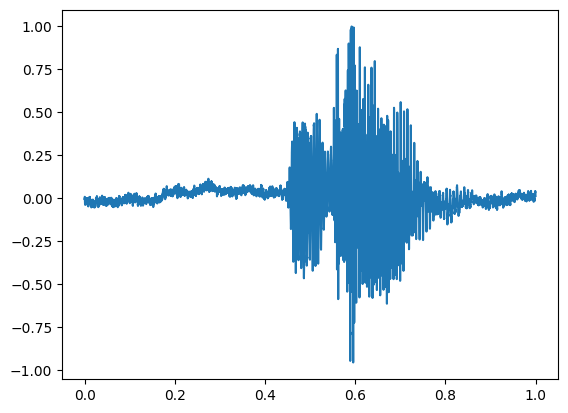


Predykcja:


I0000 00:00:1718394361.678871   67424 service.cc:145] XLA service 0x76821c003e60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1718394361.678891   67424 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
2024-06-14 21:46:01.702905: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-14 21:46:01.786801: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 969ms/step


I0000 00:00:1718394362.281475   67424 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


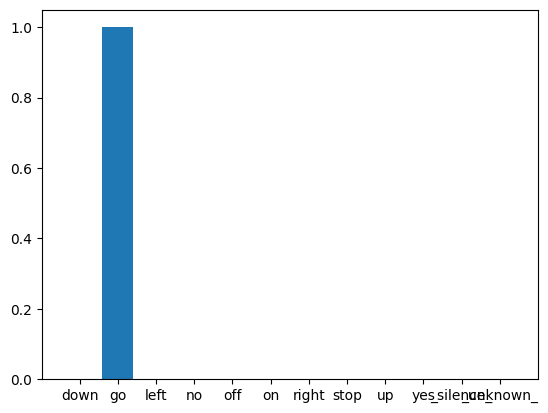

In [10]:
audio = record_audio(1)
print_prediction_results(audio)

# Przewidywanie z nagrania na dysku

Nagranie:


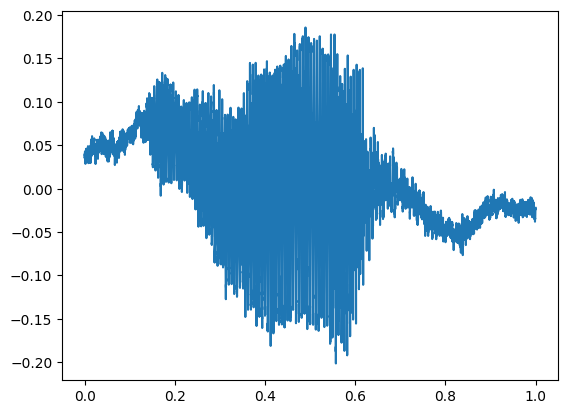


Predykcja:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


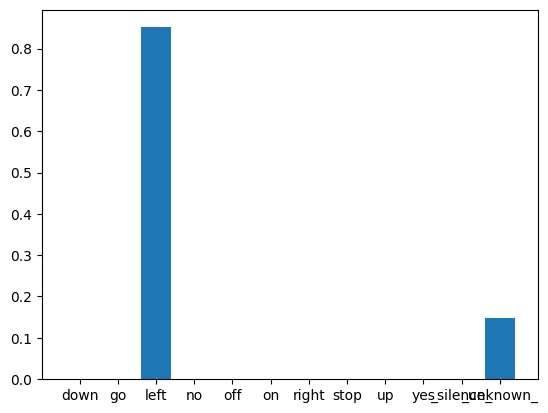

In [11]:
path = "example_audio.wav"

audio = load_audio(path)
print_prediction_results(audio)

# Metryki

## Train

2024-06-14 21:46:52.465158: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-14 21:46:53.517979: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 925.56MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


2673/2673 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step
Accuracy: 0.9959069593385647
Precision: 0.997574908387747
Recall: 0.9914432295200477


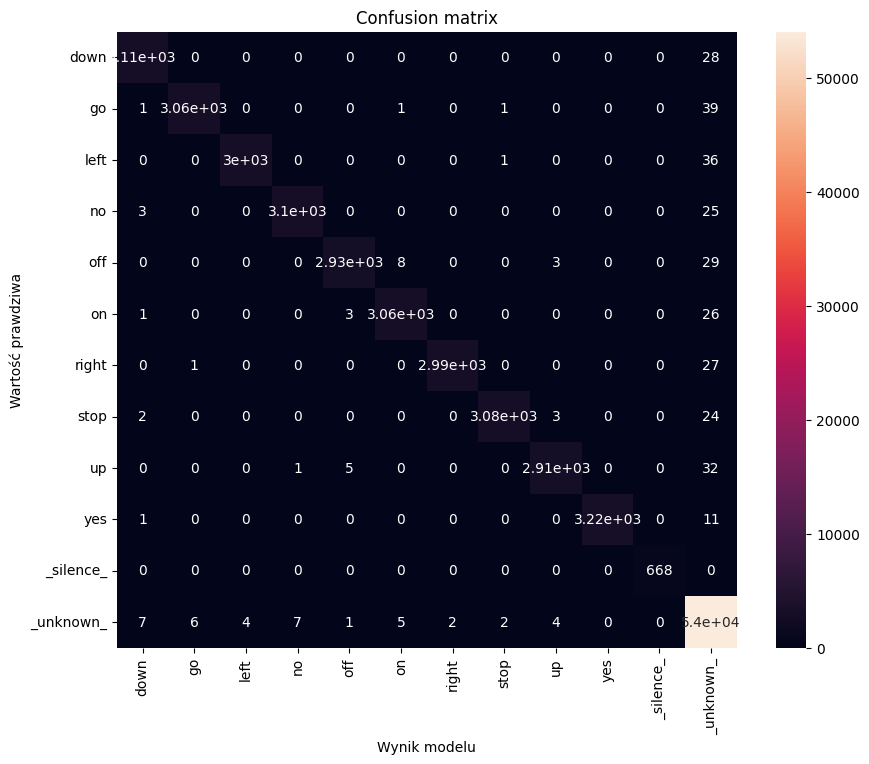

In [12]:
print_metrics(train_ds)

## Validation

 23/316 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

2024-06-14 21:47:09.191686: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


307/316 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

2024-06-14 21:47:11.015384: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 641.32MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


316/316 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
Accuracy: 0.9727776677885567
Precision: 0.9565195852206753
Recall: 0.9500564574741149


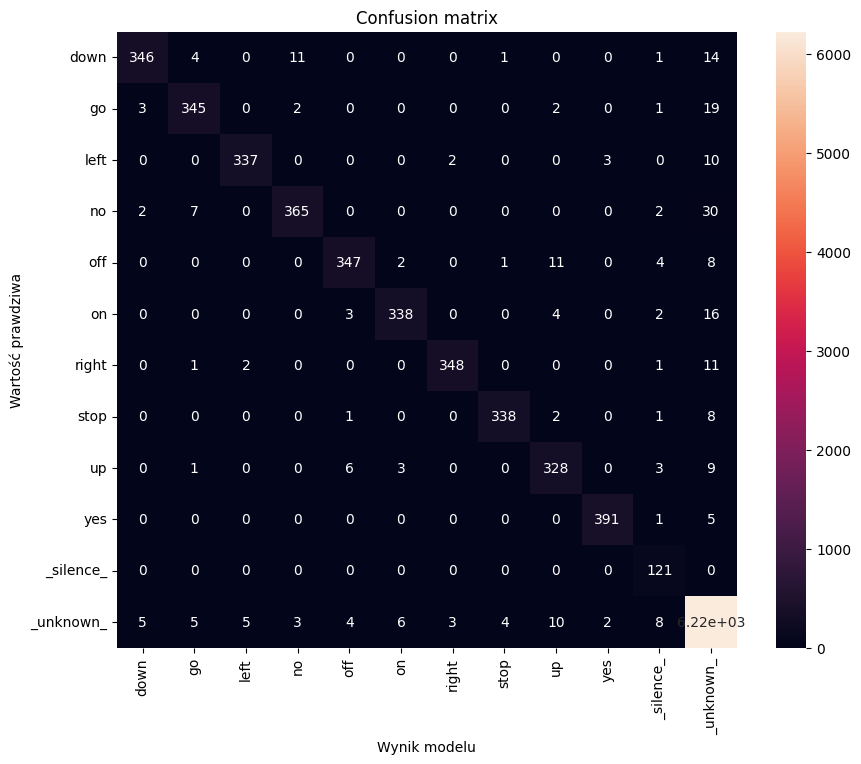

In [13]:
print_metrics(val_ds)

## Test

 23/153 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

2024-06-14 21:47:13.172489: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


150/153 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

2024-06-14 21:47:14.149998: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 755.02MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
Accuracy: 0.9492842535787321
Precision: 0.960236847285603
Recall: 0.949107245860343


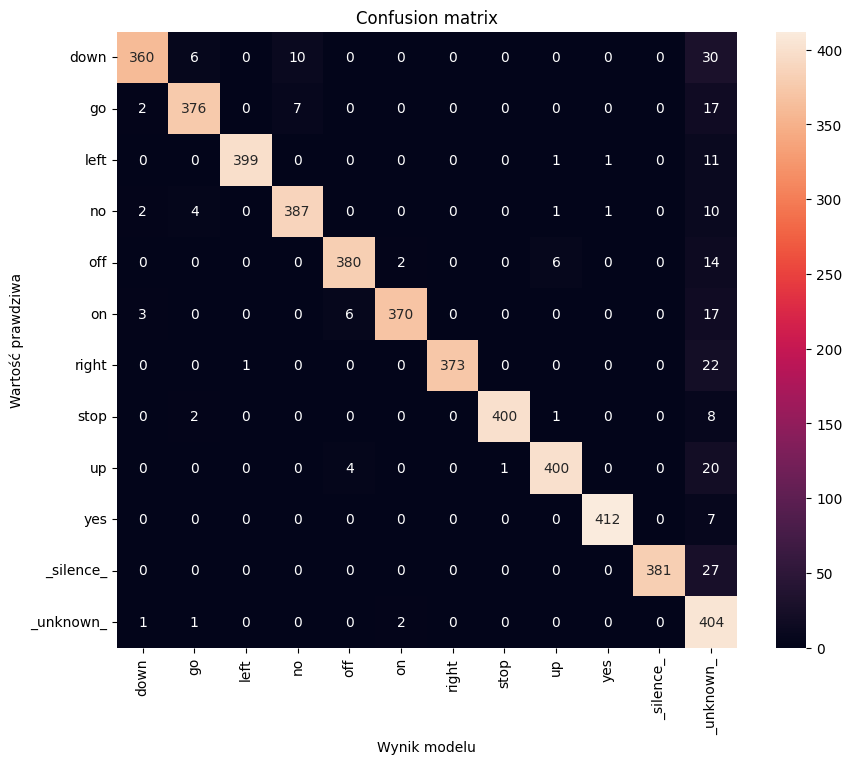

In [14]:
print_metrics(test_ds)